In [1]:
# %pip install h5py

In [2]:
import h5py
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
tf.config.run_functions_eagerly(True)

root = 'C:/Users/debnathk/Desktop/study/DLEPS-main/code/DLEPS/dleps/code/DLEPS/reference_drug/'

In [3]:
# Read datasets

h5f = h5py.File(root + 'ssp_data_train.h5')
ssp_train = h5f['data'][:]

h5f = h5py.File(root + 'ssp_data_test.h5')
ssp_test = h5f['data'][:]

h5f = h5py.File(root + 'y_train.h5')
y_train = h5f['data'][:]

h5f = h5py.File(root + 'y_test.h5')
y_test = h5f['data'][:]

In [4]:
ssp_train.shape, ssp_test.shape, y_train.shape, y_test.shape

((350, 207, 3072), (75, 207, 3072), (350,), (75,))

In [5]:
# Define the PCA model
import numpy as np
from sklearn.decomposition import PCA

# Transform training data
train_reshaped = ssp_train.reshape((350, -1))
n_components = 56
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_reshaped)

# Transform training data
test_reshaped = ssp_test.reshape((75, -1))
n_components = 56
pca = PCA(n_components=n_components)
test_pca = pca.fit_transform(test_reshaped)

In [6]:
train_pca.shape, test_pca.shape

((350, 56), (75, 56))

In [7]:
type(train_pca)

numpy.ndarray

In [8]:
# Create the regression head
inputs = Input(shape=(207, 3072))
flatten_1 = Flatten()(inputs)
x = Dense(256,activation='relu', kernel_regularizer=regularizers.l2(0.00001))(flatten_1)
x = Dropout(0.4)(x)
x = Dense(256,activation='relu', kernel_regularizer=regularizers.l2(0.00001))(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.00001))(x)
x = Dropout(0.4)(x)
x = Dense(56,activation='relu', kernel_regularizer=regularizers.l2(0.00001))(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=outputs)

In [9]:
# Compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error as metrics for regression

In [10]:
# Set up ModelCheckpoint to save weights for the epoch with the best validation loss
checkpoint_filepath = root + "sample_weights_pca.h5"
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [11]:
# Train the model and obtain the training history
history = model.fit(ssp_train, y_train, 
                         validation_data=(ssp_test, y_test), 
                         epochs=100, batch_size=25, verbose=2,
                         callbacks=[model_checkpoint]
                         )

C:\Users\debnathk\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100


Epoch 1: val_loss improved from inf to 135.08803, saving model to C:/Users/debnathk/Desktop/study/DLEPS-main/code/DLEPS/dleps/code/DLEPS/reference_drug\sample_weights_pca.h5


C:\Users\debnathk\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 - 147s - loss: 30977.6094 - mae: 131.5396 - val_loss: 135.0880 - val_mae: 10.6297 - 147s/epoch - 10s/step
Epoch 2/100

Epoch 2: val_loss improved from 135.08803 to 9.46600, saving model to C:/Users/debnathk/Desktop/study/DLEPS-main/code/DLEPS/dleps/code/DLEPS/reference_drug\sample_weights_pca.h5


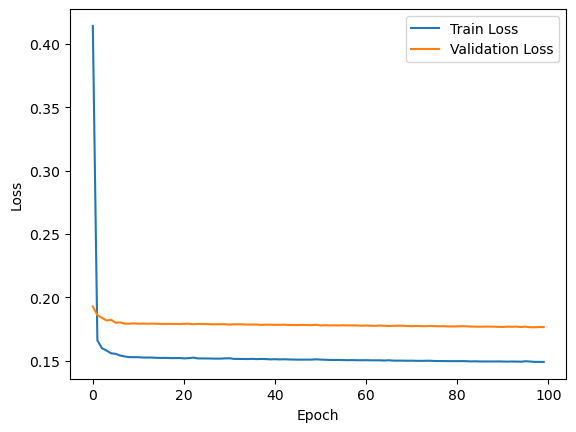

In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

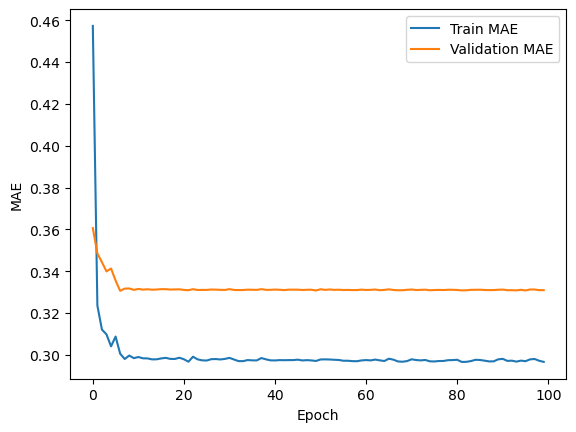

In [ ]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Load the best weights based on the optimal epoch
model.load_weights(checkpoint_filepath)

In [ ]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 98 loss: 0.17639310657978058


In [ ]:
# Evaluate the model on the test set
results = model.evaluate(ssp_test, y_test)

3/3 [==============================] - 0s 107ms/step - loss: 0.1764 - mae: 0.3312


In [ ]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 0.17639325559139252
Test MAE: 0.331194132566452


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = model.predict(ssp_test)
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

3/3 [==============================] - 1s 162ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 75 and the array at index 1 has size 15525

In [ ]:
y_test.shape, y_pred.shape

((75,), (75, 207, 1))